# Single cell impedance analysis

Copyright (c) 2025 Open Brain Institute

Authors: Aurélien Jaquier and Darshan Mandge

last modified: 02.2025

## Description

This notebook runs a single cell with a ZAP stimulus, records its current input and voltage output, uses them to compute the cell's impedance and plots the impedance vs frequency graph.

## Get the data
The emodel data required to run this notebook (hoc file, morphology file, mechanisms and EModel resource metadata json) can be downloaded from the [Blue Brain Open Data](https://registry.opendata.aws/bluebrain_opendata/). In future, you will be able to download the emodel data for different e-models directly from the Open Brain Platform.

**Steps to Get the data**
1. Install [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-welcome.html) based on [instructions](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html) for your operating system if you are running locally on your PC.
1. Run the following commands:

In [ ]:
# check if the directory exists
!if [ ! -d "cadpyr_emodel" ]; then mkdir cadpyr_emodel; fi 

#download cADpyr e-model files
# mechanisms
!aws s3 sync --no-sign-request s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/mechanisms ./cadpyr_emodel/mechanisms 
# hoc and morphology file 
!aws s3 cp --no-sign-request s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/model.hoc ./cadpyr_emodel/model.hoc
!aws s3 cp --no-sign-request s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/C060114A5.asc ./cadpyr_emodel/C060114A5.asc
#Emodel json 
!aws s3 cp --no-sign-request s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/EM__emodel=cADpyr__etype=cADpyr__mtype=L5_TPC_A__species=mouse__brain_region=grey__iteration=1372346__13.json ./cadpyr_emodel/metadata.json

The emodel files will be downloaded `cadpyr_emodel` folder. Next, you will need to compile the mechanisms located in the emodel folder:

In [ ]:
!nrnivmodl cadpyr_emodel/mechanisms

You will also need to have Neuron, BlueCelluLab, BluePyEModel and matplotlib installed. Now, we'll have to load every module that are needed in this notebook:

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import zipfile

from bluecellulab import Cell
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.simulation import Simulation
from bluecellulab.stimulus import StimulusFactory
from bluecellulab.tools import calculate_rheobase
from bluepyemodel.emodel_pipeline.plotting_utils import get_impedance


In [2]:
emodel_folder = Path("cadpyr_emodel")
# Load the metadata json
with open(emodel_folder / "metadata.json") as f:
    metadata = json.load(f)

hoc_file = emodel_folder / "model.hoc"
morph_file = emodel_folder / "C060114A5.asc"
mechanisms_folder = emodel_folder / "mechanisms"
emodel_name = "cADpyr"

Now we want to get the threshold and holding current of the emodel. Let get them from the `metadata` dictionary. The dictionary was created using the EModel json resource and has the final optimised parameters, efeatures scores, efeatures values and other emodel data (See parameters_plot notebook and README for more details):

In [3]:
metadata.keys()

dict_keys(['fitness', 'parameter', 'score', 'features', 'scoreValidation', 'passedValidation', 'seed'])

The threshold and holding currents are stored in within `metadata` under the `features` list of dictionaries. Here is how one of `features` dictionationary looks like:

In [4]:
metadata["features"][0]

{'name': 'IDrest_130.soma.v.Spikecount', 'value': 17.0, 'unitCode': ''}

The dictionaies with key `name` as `SearchThresholdCurrent.soma.v.bpo_threshold_current` and `SearchHoldingCurrent.soma.v.bpo_holding_current` contain the thrshold and holding current of the emodel. Let's get these values

In [5]:
# assigning variables for the keys search in metadata
hc_key = "SearchHoldingCurrent.soma.v.bpo_holding_current"
tc_key = "SearchThresholdCurrent.soma.v.bpo_threshold_current"

def get_feature_value(features, key):
	for feature_dict in features:
		if key in feature_dict["name"]:
			return feature_dict["value"]
	return None

holding_current = get_feature_value(metadata["features"], hc_key)
threshold_current = get_feature_value(metadata["features"], tc_key)

print(f"Threshold Current = {threshold_current} nA")
print(f"Holding Current = {holding_current} nA")

Threshold Current = 0.1624028733588378 nA
Holding Current = -0.08750000000000001 nA


If the holding current and the threshold current are not available, we will use default values of 0 for both for now, and compute the threshold current later on.

In [6]:
if holding_current is None:
    print("No holding current provided, will set it to 0.")
    holding_current = 0
compute_threshold = False
if threshold_current is None:
    compute_threshold = True
    threshold_current = 0
emodel_properties = EmodelProperties(
    threshold_current=threshold_current,
    holding_current=holding_current,
)

Now that we have the holding and threshold current (or placeholder values if they were not in the metadata), we can create our cell using BlueCelluLab:

In [7]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

Now that we have a cell, we can compute its threshold current if it was not provided in the metadata. First, we compute its RMP (resting membrane potential) and Rin (internal resistance) to get a maximum bound for threshold current, and use a bisection search algorithm. BlueCelluLab can handle all of that:

In [8]:
if compute_threshold:
    print("No threshold current provided, will attempt to compute it. This will take a few seconds...")
    emodel_properties.threshold_current = calculate_rheobase(cell)

And we can print the holding and threshold currents:

In [10]:
print(f"threshold current is {emodel_properties.threshold_current} nA.")
print(f"holding current is {emodel_properties.holding_current} nA.")

threshold current is 0.1624028733588378 nA.
holding current is -0.08750000000000001 nA.


We will now create a sinespec protocol with a ZAP stimulus. We will provide a small delay of 300 ms in order to let the cell settle to its resting state before stimulating it. We can also set the time step. Here, we will set to 0.1 ms. Once again, BlueCelluLab takes care of creating the stimulus for us:

In [11]:
stim_factory = StimulusFactory(dt=0.1)
sinespec = stim_factory.sinespec(threshold_current=emodel_properties.threshold_current, pre_delay=300)

Now, we can inject the stimulus into the cell, run it, and get its recorded time, current input, and voltage output. The voltage recording is already defined in BlueCelluLab, but not the injected current, so we have to add it as a recording by hand. Note that this can take a few seconds to run.

In [12]:
cell.inject_current_waveform(t_content=sinespec.time, i_content=sinespec.current)
current_rec = "neuron.h.IClamp[0]._ref_i"
cell.add_recording(current_rec)
sim = Simulation(cell)
print("Running the simulation...")
sim.run(sinespec.stimulus_time, dt=0.1)
print("Done.")
time, voltage, current = cell.get_time(), cell.get_soma_voltage(), cell.get_recording(current_rec)

Running the simulation...
Done.


Now, we can compute the impedance at all frequencies up to 50 Hz, and extract the frequency at which the impedance is maximal, using the BluePyEModel get_impedance function:

In [13]:
freq, smooth_Z = get_impedance(
    time,
    voltage,
    current,
    300.0,
    5300.0,
    efel_settings={},
)
if freq is None or smooth_Z is None:
    raise TypeError("Could not compute the impedance.")
imp_arg = np.argmax(smooth_Z)
imp_freq = freq[imp_arg]
print(f"Impedance is maximal at {imp_freq} Hz.")

Impedance is maximal at 3.012747177585161 Hz.


Finally, we can plot our input current trace, output voltage trace, and impedance vs frequency plot, and save it as a pdf in the figures folder:

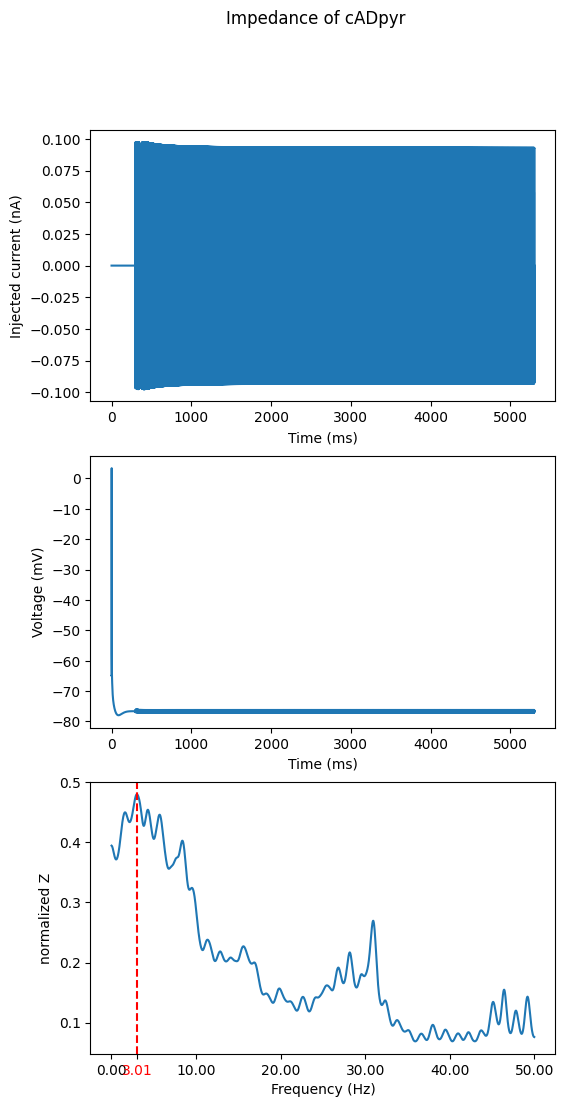

In [14]:
fig, axs = plt.subplots(3, figsize=(6, 12))
axs[0].plot(time, current)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Injected current (nA)")

# voltage trace
axs[1].plot(time, voltage)
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Voltage (mV)")

# impedance trace
axs[2].plot(freq, smooth_Z)
axs[2].axvline(imp_freq, ls="--", c="red")
xlim = axs[2].get_xlim()
new_xticks = list(axs[2].get_xticks()) + [imp_freq]
axs[2].set_xticks(new_xticks)
axs[2].xaxis.get_ticklabels()[-1].set_color("red")
# we have to re-set xlim after adding an xtick
axs[2].set_xlim(xlim)
axs[2].set_xlabel("Frequency (Hz)")
axs[2].set_ylabel("normalized Z")

fig.suptitle(f"Impedance of {emodel_name}")

output_path = Path("figures")
output_path.mkdir(exist_ok=True)
plt.savefig(output_path / "impedance_analysis.pdf")
plt.show()